In [1]:
"""Imports"""
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

In [2]:
"""Hyperparameters for pretraining"""
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [3]:
"""Load and prepare the CIFAR-10 dataset"""
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 [==============================] - 15s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [4]:
"""Data augmentation"""
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [5]:
"""A layer for extracting patches from images"""
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 102.


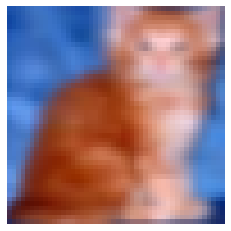

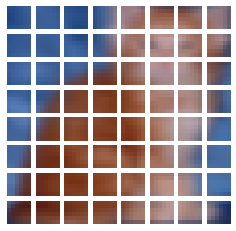

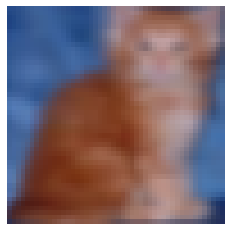

In [6]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [7]:
"""Patch encoding with masking"""
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

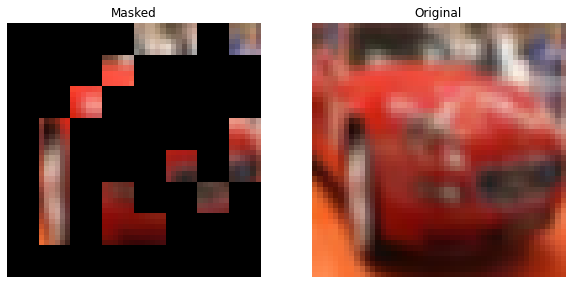

In [8]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [14]:
"""MLP"""
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
"""MAE encoder"""
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [15]:
"""MAE decoder"""
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [12]:
"""MAE trainer"""
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [13]:
"""Model initialization"""
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [16]:
"""Training callbacks"""
## Visualization callback
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

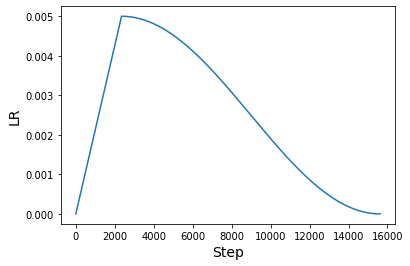

In [17]:
## Learning rate scheduler
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.0502 - mae: 0.1798
Idx chosen: 92


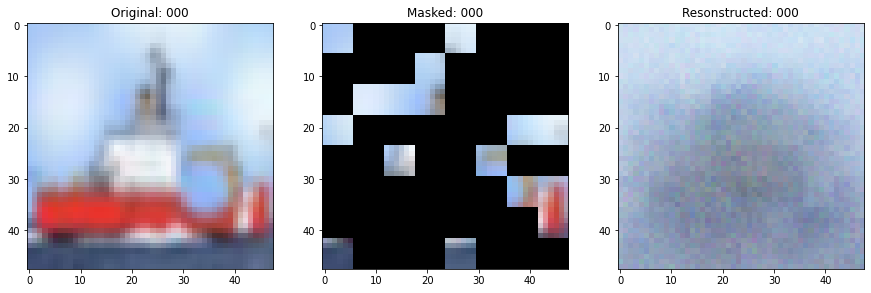

157/157 [==============================] - 278s 2s/step - loss: 0.0502 - mae: 0.1798 - val_loss: 0.0420 - val_mae: 0.1640
Epoch 2/100
157/157 [==============================] - 252s 2s/step - loss: 0.0373 - mae: 0.1519 - val_loss: 0.0351 - val_mae: 0.1444
Epoch 3/100
157/157 [==============================] - 254s 2s/step - loss: 0.0317 - mae: 0.1370 - val_loss: 0.0310 - val_mae: 0.1356
Epoch 4/100
157/157 [==============================] - 250s 2s/step - loss: 0.0286 - mae: 0.1289 - val_loss: 0.0278 - val_mae: 0.1257
Epoch 5/100
157/157 [==============================] - 240s 2s/step - loss: 0.0258 - mae: 0.1213 - val_loss: 0.0258 - val_mae: 0.1213
Epoch 6/100
157/157 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.1153
Idx chosen: 14


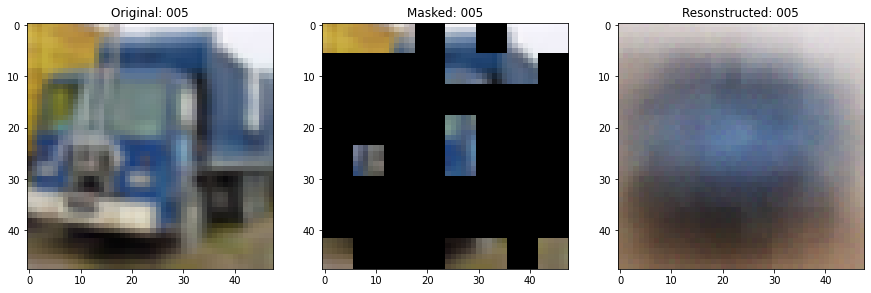

157/157 [==============================] - 226s 1s/step - loss: 0.0236 - mae: 0.1153 - val_loss: 0.0236 - val_mae: 0.1149
Epoch 7/100
157/157 [==============================] - 231s 1s/step - loss: 0.0219 - mae: 0.1104 - val_loss: 0.0222 - val_mae: 0.1100
Epoch 8/100
157/157 [==============================] - 237s 2s/step - loss: 0.0209 - mae: 0.1073 - val_loss: 0.0207 - val_mae: 0.1058
Epoch 9/100
157/157 [==============================] - 235s 1s/step - loss: 0.0205 - mae: 0.1062 - val_loss: 0.0208 - val_mae: 0.1084
Epoch 10/100
157/157 [==============================] - 240s 2s/step - loss: 0.0195 - mae: 0.1029 - val_loss: 0.0207 - val_mae: 0.1043
Epoch 11/100
157/157 [==============================] - ETA: 0s - loss: 0.0192 - mae: 0.1019
Idx chosen: 106


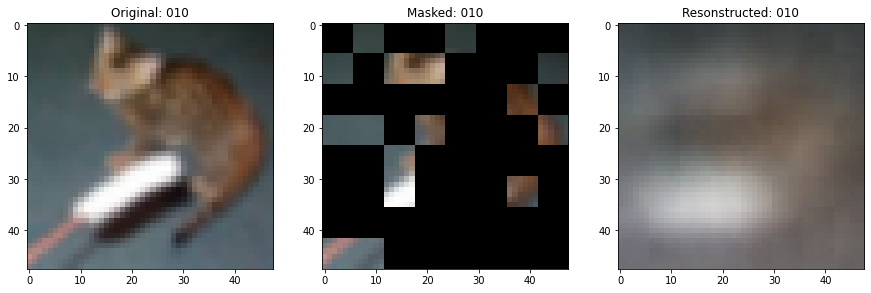

157/157 [==============================] - 244s 2s/step - loss: 0.0192 - mae: 0.1019 - val_loss: 0.0201 - val_mae: 0.1039
Epoch 12/100
157/157 [==============================] - 222s 1s/step - loss: 0.0189 - mae: 0.1011 - val_loss: 0.0199 - val_mae: 0.1029
Epoch 13/100
 50/157 [========>.....................] - ETA: 2:20 - loss: 0.0190 - mae: 0.1014

KeyboardInterrupt: 

In [18]:
"""Model compilation and training"""
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

In [19]:
"""Evaluation with linear probing"""
## Extract the encoder model along with other layers
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_1 (Patches)         (None, 64, 108)           0         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 64, 128)          22252     
 er)                                                             
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [20]:
## Prepare datasets for linear probing
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [21]:
## Perform linear probing
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
  7/157 [>.............................] - ETA: 3:21 - loss: 2.6631 - accuracy: 0.1010

KeyboardInterrupt: 